This is only done for testing purposes.
Beware of:
p-value hacking
look-ahead bias 
overfitting

In [1]:
from binance.client import Client
import pandas as pd
c = Client()

In [2]:
# Obtain all the pairs from Binance
products = c.get_products()

In [3]:
# Obtain all the pairs with the USDT bridge
coins = []
for i in products['data']:
    items = i.items()
    
    for i in items:
        if 's' in i and 'USDT' in i[1]:
            coins.append(i[1])
            
# df = pd.DataFrame(coins, columns=['coin'])
# df.head()

In [4]:
# Obtains data for a specified symbol, interval and limit
# Can be modified by adding start and end dates
def GetData (symbol, interval, limit):
    data = c.get_klines(symbol=symbol, interval=interval, limit=limit)
    x = 0
    full = {}

    for k in data:
        #print(k)
        j = []
        x += 1
        for i in k[:5]:
            j.append(float(i))
        dat = pd.DataFrame(j).T
        full[str(x)] = dat

    df = pd.concat(full)
    df.reset_index(drop=True, inplace=True)
    df.columns = ['date','open','high','low','close']
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df = df.assign(ticker=symbol)
    return(df)

In [5]:
historical = pd.DataFrame()
hist = {}

for i in coins:
    coin_hist = GetData(symbol=i, interval='1d', limit=730)
    hist[i] = coin_hist
#hist

In [6]:
data = pd.concat(hist)
data.reset_index(drop=True, inplace=True)
data.head()

,date,open,high,low,close,ticker
0,2019-06-02,8545.10,8814.78,8524.00,8725.98,BTCUSDT
1,2019-06-03,8726.00,8800.95,8080.80,8115.82,BTCUSDT
2,2019-06-04,8115.66,8115.66,7481.02,7687.03,BTCUSDT
3,2019-06-05,7687.04,7896.70,7572.78,7776.50,BTCUSDT
4,2019-06-06,7778.08,7868.13,7444.58,7786.70,BTCUSDT


In [7]:
data.to_csv('USDT_Bridge_Coins')

In [33]:
df = pd.read_csv('USDT_Bridge_Coins')

In [34]:
df = data.pivot(index='date', columns='ticker', values='close')
df.head()

ticker,1INCHUSDT,AAVEUSDT,ACMUSDT,ADAUSDT,AIONUSDT,AKROUSDT,ALGOUSDT,ALICEUSDT,ALPHAUSDT,ANKRUSDT,...,XMRUSDT,XRPUSDT,XTZUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
date,,,,,,,,,,,,,,,,,,,,,
2019-06-02,NaN,NaN,NaN,0.09630,NaN,NaN,NaN,NaN,NaN,NaN,...,94.77,0.44396,NaN,NaN,NaN,NaN,88.86,NaN,0.02176,0.3405
2019-06-03,NaN,NaN,NaN,0.08745,NaN,NaN,NaN,NaN,NaN,NaN,...,88.85,0.41731,NaN,NaN,NaN,NaN,83.63,NaN,0.02076,0.3169
2019-06-04,NaN,NaN,NaN,0.08247,NaN,NaN,NaN,NaN,NaN,NaN,...,83.65,0.39878,NaN,NaN,NaN,NaN,77.69,NaN,0.02192,0.3038
2019-06-05,NaN,NaN,NaN,0.08252,NaN,NaN,NaN,NaN,NaN,NaN,...,84.65,0.40010,NaN,NaN,NaN,NaN,80.41,NaN,0.02137,0.3143
2019-06-06,NaN,NaN,NaN,0.08308,NaN,NaN,NaN,NaN,NaN,NaN,...,86.69,0.41937,NaN,NaN,NaN,NaN,79.65,NaN,0.02322,0.3205


In [35]:
naughty = ('BUSDTRY','BUSDUSDT','BNBUSDT')
for i in naughty:
    df.pop(i)

<AxesSubplot:>

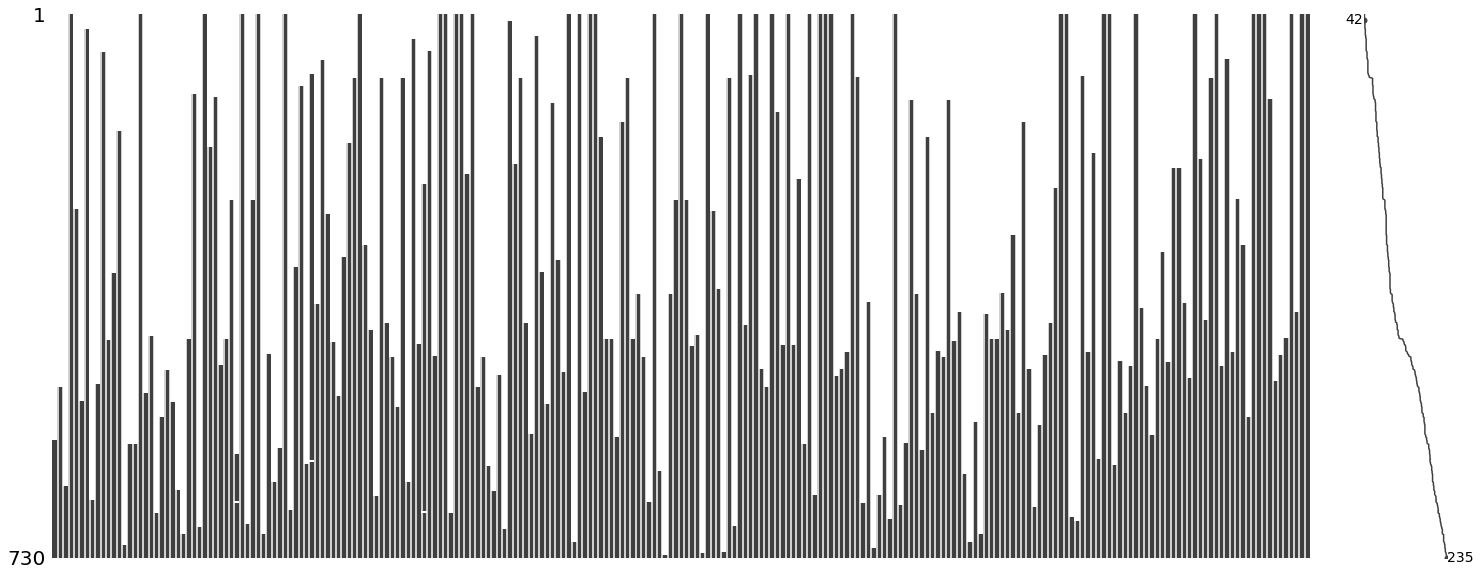

In [36]:
import missingno
missingno.matrix(df)

In [37]:
print('Data Shape before cleaning =', df.shape)

missing_percentage = df.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
df.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', df.shape)

Data Shape before cleaning = (730, 235)
Data Shape after cleaning = (730, 71)


In [38]:
df = df.fillna(method='ffill')

In [39]:
import numpy as np

#Calculate # returns and create a data frame
returns = df.pct_change().mean()*90
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = df.pct_change().std()*np.sqrt(90)

df = returns
df.head()

,returns,volatility
ticker,,
ADAUSDT,0.529379,0.595059
ALGOUSDT,0.146918,0.711205
ANKRUSDT,0.672742,0.823826
ATOMUSDT,0.311106,0.652657
BANDUSDT,0.785184,0.919956


In [40]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(df)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(df), columns=df.columns, index=df.index)
X = scaled_data
X.head()

,returns,volatility
ticker,,
ADAUSDT,-0.115474,-0.122137
ALGOUSDT,-0.133591,-0.120089
ANKRUSDT,-0.108683,-0.118103
ATOMUSDT,-0.125814,-0.121121
BANDUSDT,-0.103356,-0.116408


k-Means Clustering

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

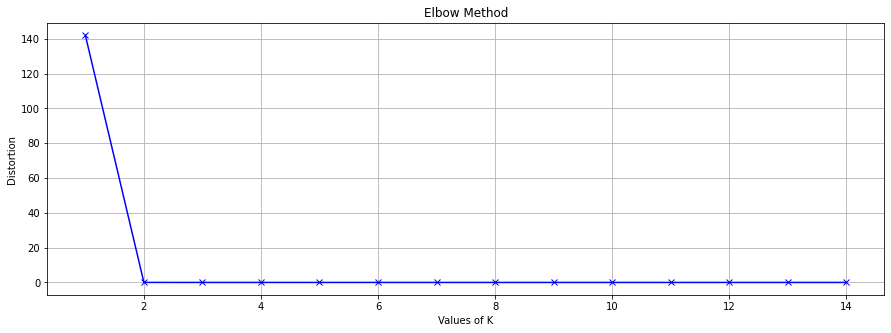

In [42]:
K = range(1,15) 
distortions = []  

for k in K:  
    kmeanModel = KMeans(n_clusters=k)  
    kmeanModel.fit(X)  
    distortions.append(kmeanModel.inertia_)
    
#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

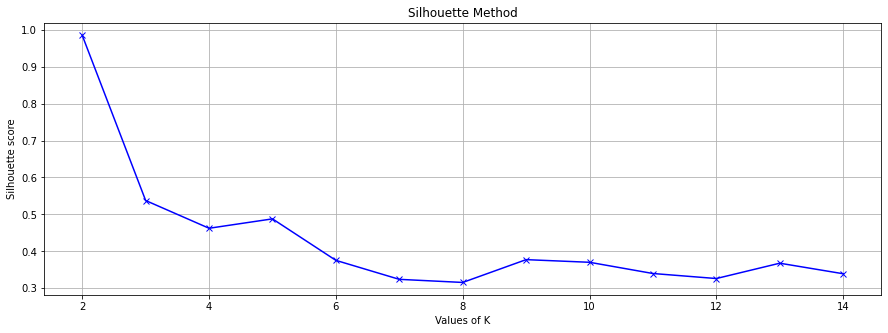

Suggested number of clusters:  4


In [43]:
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

In [44]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

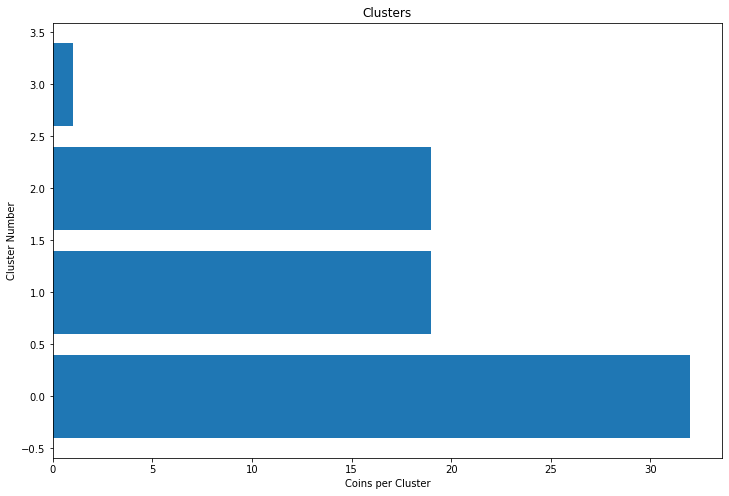

In [45]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Coins per Cluster')
plt.ylabel('Cluster Number')
plt.show()

Affinity Propagation Clustering

In [46]:
from sklearn.cluster import AffinityPropagation

#Fit the model
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

In [47]:
from itertools import cycle

cci = ap.cluster_centers_indices_
labels2 = ap.labels_

clusters = len(cci)
print('The number of clusters is:',clusters)

The number of clusters is: 9


In [48]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.46063277324150864
Affinity Propagation Clustering 0.43655886362549334


In [49]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 3
Number of Pairs: 1676


In [50]:
def find_coint_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [51]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(df.T[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
#print(pairs)

Number of pairs: 67
In those pairs, we found 70 unique tickers.


In [52]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

,returns,volatility
ticker,,
ADAUSDT,-0.115474,-0.122137
ALGOUSDT,-0.133591,-0.120089
ANKRUSDT,-0.108683,-0.118103
ATOMUSDT,-0.125814,-0.121121
BANDUSDT,-0.103356,-0.116408


In [53]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)
#X_tsne

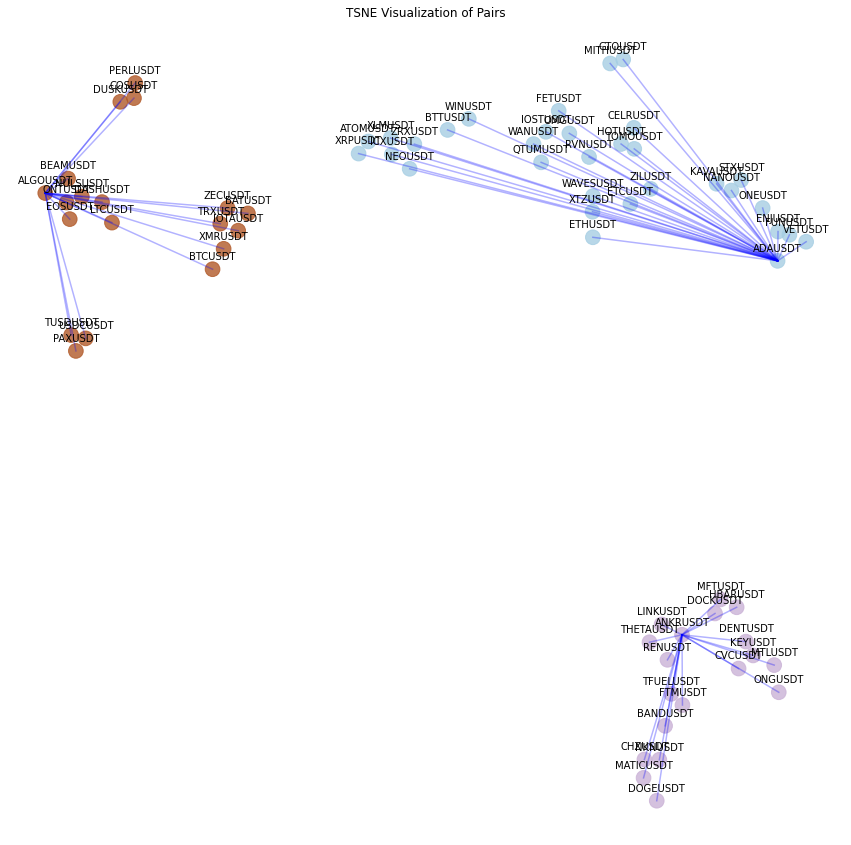

In [54]:
plt.figure(1, facecolor='white',figsize=(15,15))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()

In [30]:
pairs

[('ADAUSDT', 'ATOMUSDT'),
 ('ADAUSDT', 'BTTUSDT'),
 ('ADAUSDT', 'CELRUSDT'),
 ('ADAUSDT', 'ENJUSDT'),
 ('ADAUSDT', 'ETCUSDT'),
 ('ADAUSDT', 'ETHUSDT'),
 ('ADAUSDT', 'FETUSDT'),
 ('ADAUSDT', 'FUNUSDT'),
 ('ADAUSDT', 'GTOUSDT'),
 ('ADAUSDT', 'HOTUSDT'),
 ('ADAUSDT', 'ICXUSDT'),
 ('ADAUSDT', 'IOSTUSDT'),
 ('ADAUSDT', 'KAVAUSDT'),
 ('ADAUSDT', 'MITHUSDT'),
 ('ADAUSDT', 'NANOUSDT'),
 ('ADAUSDT', 'NEOUSDT'),
 ('ADAUSDT', 'OMGUSDT'),
 ('ADAUSDT', 'ONEUSDT'),
 ('ADAUSDT', 'QTUMUSDT'),
 ('ADAUSDT', 'RVNUSDT'),
 ('ADAUSDT', 'STXUSDT'),
 ('ADAUSDT', 'TOMOUSDT'),
 ('ADAUSDT', 'VETUSDT'),
 ('ADAUSDT', 'WANUSDT'),
 ('ADAUSDT', 'WAVESUSDT'),
 ('ADAUSDT', 'WINUSDT'),
 ('ADAUSDT', 'XLMUSDT'),
 ('ADAUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'XTZUSDT'),
 ('ADAUSDT', 'ZILUSDT'),
 ('ADAUSDT', 'ZRXUSDT'),
 ('ALGOUSDT', 'BATUSDT'),
 ('ALGOUSDT', 'BEAMUSDT'),
 ('ALGOUSDT', 'BTCUSDT'),
 ('ALGOUSDT', 'COSUSDT'),
 ('ALGOUSDT', 'DASHUSDT'),
 ('ALGOUSDT', 'DUSKUSDT'),
 ('ALGOUSDT', 'EOSUSDT'),
 ('ALGOUSDT', 'IOTAUSDT'),
 ('